In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob


### Unfiltered

In [2]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
# file2 = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5"

f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

In [3]:
time_subsample = 1
full_dat = data[7500:12500,::time_subsample]

for i in np.arange(12,16):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat = np.hstack((full_dat,data[7500:12500,::time_subsample]))

In [4]:
# np.arange(11,31).shape

n = 1.4682
L = 51.04762
full_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*full_dat[:,::10]

# EDIT!!!

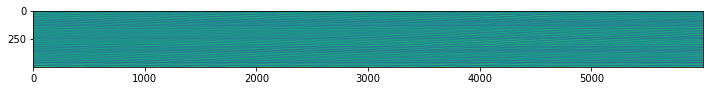

In [7]:
plt.figure(figsize=(12,10))
plt.imshow(full_dat[::10,:]*10**6, vmin=-5.,vmax=5.)
plt.show()

In [9]:
np.amax(full_dat*10**6)

3.9041612325330446

In [10]:
dt=1. #/200
working_dat = full_dat[:,:]*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])#*2.0419047

# time = dt*np.arange(working_dat.shape[0])

In [11]:
xs.shape

(5000,)

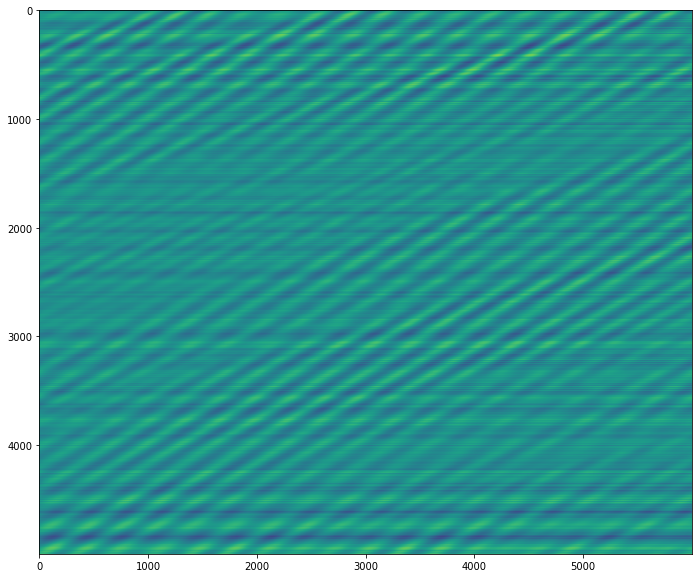

In [12]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0], vmin=-5.,vmax=5.)
plt.show()

In [13]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [28]:
thresh = 1e-3
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff16c82c910>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.001))

In [29]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.001
(x0)' = 0.005 x0_1 + 0.003 x0_111


In [14]:
thresh = 5e-5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff16c82c910>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=5e-05))

In [16]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 5e-05
(x0)' = 0.005 x0_1 + 0.003 x0_111


In [36]:
thresh = 1e-8
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff16c82c910>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1e-08))

In [37]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-08
(x0)' = 0.005 x0_1 + 0.003 x0_111


### drift removal

In [38]:
A_channel = np.hstack((np.arange(full_dat.shape[1]).reshape((-1,1)),np.ones(full_dat.shape[1]).reshape((-1,1))))
coeffs = np.zeros((full_dat.shape[0],2))
for channel in range(full_dat.shape[0]):
    coeffs[channel,:] = np.linalg.lstsq(A_channel, full_dat[channel,:], rcond=None)[0]
    

In [39]:
drift_removal = np.zeros(full_dat.shape)
for channel in range(full_dat.shape[0]):
    drift_removal[channel,:] = full_dat[channel,:]-(coeffs[channel,0]*A_channel[:,0] + coeffs[channel,1])

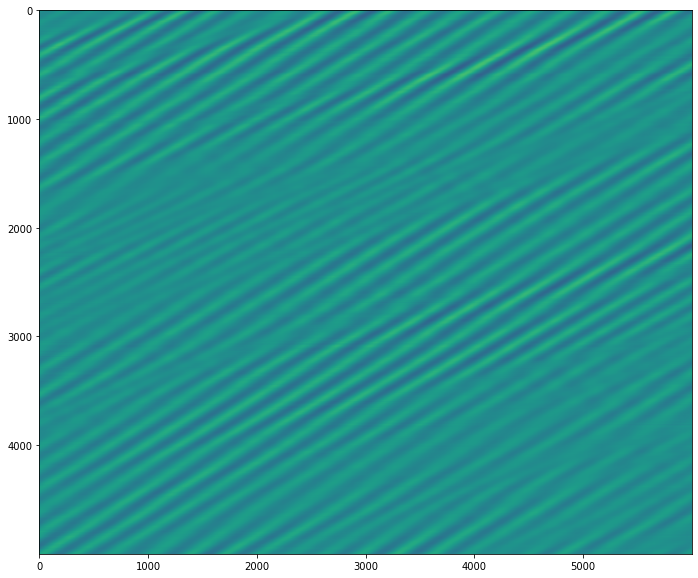

In [41]:
plt.figure(figsize=(12,10))
plt.imshow(drift_removal[:,:]*10**6, vmin=-5.,vmax=5.)
plt.show()

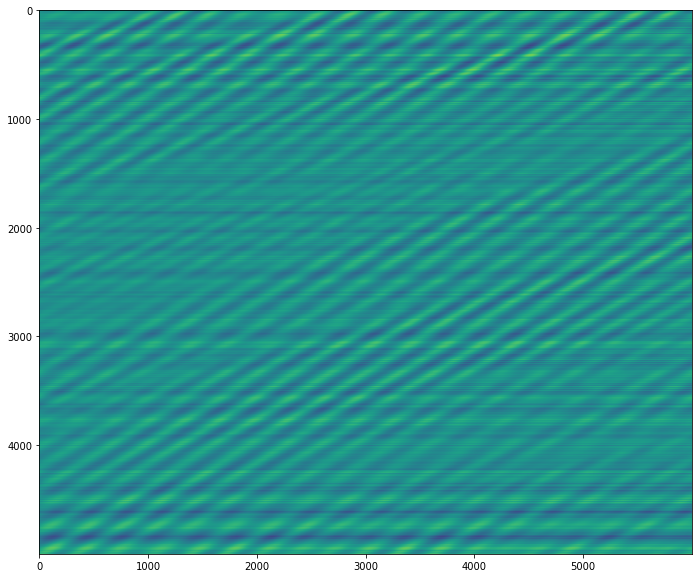

In [42]:
plt.figure(figsize=(12,10))
plt.imshow(full_dat[:,:]*10**6, vmin=-5.,vmax=5.)
plt.show()

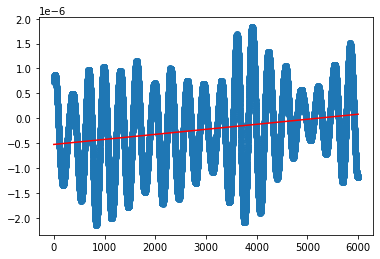

In [43]:
plt.figure()
plt.scatter(A_channel[:,0],full_dat[587,:])
plt.plot(A_channel[:,0],coeffs[587,0]*A_channel[:,0] + coeffs[587,1],c='r')

plt.show()

In [44]:
dt=1. #/200
working_dat = drift_removal[:,:]*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])#*2.0419047

# time = dt*np.arange(working_dat.shape[0])

In [45]:
xs.shape

(5000,)

In [46]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [50]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff167a316d0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=50))

In [51]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.235 x0_1 + 0.107 x0_111


In [58]:
thresh = 0.05
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff167a316d0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.05))

In [59]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.235 x0_1 + 0.107 x0_111


In [54]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff167a316d0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [55]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.265 x0_1 + 0.123 x0_111 + -0.070 x0x0x0_1 + -0.035 x0x0x0_111


### Filtered



In [60]:
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")

In [66]:
n = 1.4682
L = 51.04762

b=0
for q in np.arange(5):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))
        
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat *10**6#/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

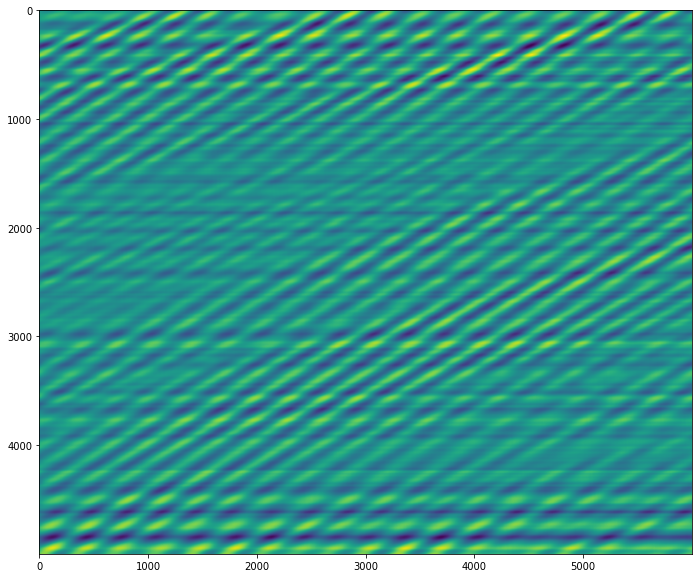

In [82]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [68]:
xs = np.arange(working_dat.shape[0])
print(xs.shape)

(5000,)


In [69]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [78]:
thresh = 0.8
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff16a015790>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.8))

In [79]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.8
(x0)' = -6.298 x0_111


In [70]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff16a015790>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=50))

In [71]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.431 x0_1 + 18.967 x0_111 + 1.313 x0x0x0_111


In [72]:
thresh = 0.05
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff16a015790>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.05))

In [73]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.431 x0_1 + 18.948 x0_111 + -0.897 x0x0_111 + 1.297 x0x0x0_111
